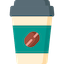

# Web Scraping Coffee Reviews with BeautifulSoup

[Coffee Review](https://www.coffeereview.com/) is an influential online coffee buying guide - users conduct blind, expert tastings of coffee 
that are documented in detailed reviews and summaries. 4700+ reviews are available to users - key details include roast level, roaster location, blind asssessments, tasting notes, and other free-text features.

Reviews are well-standardized and uniform. This Python script scrapes, munges, and exports all reviews into a structured CSV.

##### View this notebook in [Google Colab](https://colab.research.google.com/drive/1Drc7Wetzf91ypy3QoMb536YV1IDXJIZK?usp=sharing)

# Import Resources

Mount Google Drive and import required libaries - including `pandas` and `BeautifulSoup`.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
import re
import bs4

# Scrape and Store Slugs for all Coffee Reviews

The coffee review data is accessible thru an advanced search page - users can paginate thru this page to explore and select different reviews.

This process generates a list of slugs - each slug represents a hyperlink to a unique review. We will use this list as the input to our scraping method later in the workbook.

In [ ]:
# Define Slug Extraction Function

def extract_slugs (max_page_id):

  # Initialize empty list of coffee review names and slugs
  name_slug_list = []

  # Iterate through 257 pages of coffee reviews
  print('Begin Scraping!')
  for i in range(1,max_page_id+1):
      url = 'https://www.coffeereview.com/advanced-search/?pg={}'.format(i)
      res = requests.get(url,headers = {'User-agent': 'Lisa Vanderpump'})
      soup = BeautifulSoup(res.content, "lxml")
      names = soup.find_all('p',{'class':"review-title"})
      
      #collect name and slugs
      for name in names:
          ns_dict ={}
          ns_dict['name'] = name.text
          ns_dict['slug'] = name.find('a').attrs['href']
          
          #add dictionary to list
          name_slug_list.append(ns_dict)
      
      #counter
      if (i%25) == 0:
          print(f'scraped {i} pages')

      #pause between requests
      time.sleep(1)

      return name_slug_list

In [ ]:
# Execute Function
name_slug_list = extract_slugs(257)

In [ ]:
# Export Slugs to Local Filesystem
name_slug_df=pd.DataFrame(name_slug_list)
name_slug_df.to_csv('/content/drive/MyDrive/name_slug.csv')

# Scrape and Store Review Data

We use a custom function that leverages `requests` and `BeautifulSoup` to iterate thru our list of slugs, visit it's corresponding URL, and download the HTML content from the page.

Reviews are well-organized and standardized - HTML elements between reviews do not change. With that, we use `BeautifulSoup` to identify and extract information from the div elements that contain data of interest.

In [ ]:
# Define Prcessing Function

def process_slug(slug):
  results={}
  try:
    url = 'https://www.coffeereview.com{}'.format(slug)
    res = requests.get(url,headers = {'User-agent': 'Kyle Richards'})
    soup = BeautifulSoup(res.content, "lxml")

    try:
      results['score'] = soup.find('span',{'class':'review-template-rating'}).text
    except:
      results['score']= 'Not Available'

    try:
      results['roaster'] = soup.find('p',{'class':'review-roaster'}).text
    except:
      results['roaster']= 'Not Available'

    try:
      results['title'] = soup.find('h1',{'class':'review-title'}).text
    except:
      results['title']= 'Not Available'   

    table_elements= soup.find_all('table',{'class':'review-template-table'})
    table_elements = pd.read_html(str(table_elements))[0]
    
    for i,j in enumerate(table_elements.iloc[:,0]):
      results[j.replace(':','')]=table_elements.iloc[:,1][i]

    for strong_tag in soup.find_all('strong'):
        if 'Blind Assessment' in strong_tag.text:
          results['blind_assessment']= strong_tag.next_sibling
        if 'Notes' in strong_tag.text:
          results['notes']= strong_tag.next_sibling
        if 'The Bottom Line' in strong_tag.text:
          results['bottom_line']= strong_tag.next_sibling
    return results
  except Exception as e:
    return e

In [ ]:
# List Comprehension to Process All Slugs

review_data=[print(str(w)+'/'+str(len(name_slug_df.slug)))or process_slug(x) for w,x in enumerate(name_slug_df.slug)]

In [ ]:
# Table our data and export to local filesystem

all_review_data=pd.DataFrame.from_records([x for x in review_data if isinstance(x,dict)])
all_review_data.to_csv('/content/drive/MyDrive/all_review_data.csv')

In [ ]:
# BeautifulSoup didn't quite remove all HTML content from our slugs
# We use a quick type-check to extract content from HTML tags

def striphtml(data):
    if isinstance(data,bs4.element.Tag):
      return data.text
    else:
      return data

In [ ]:
# Export Our Data!

all_review_data['notes']=[striphtml(x) for x in all_review_data['notes']]
all_review_data.to_csv('/content/drive/MyDrive/all_review_data.csv')